# modeling

In [1]:
import pandas as pd
import geopandas as gpd

## load data

In [2]:
train_test = gpd.read_file('../data/train_test.shp')

In [3]:
train_test.shape

(4325, 19)

In [4]:
train_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   district    4325 non-null   object  
 1   year        4325 non-null   object  
 2   month       4325 non-null   object  
 3   sss         4325 non-null   float64 
 4   sss_lag_1   4325 non-null   float64 
 5   sss_lag_2   4325 non-null   float64 
 6   chlor_a     4325 non-null   float64 
 7   chlor_a_la  4325 non-null   float64 
 8   chlor_a__1  4325 non-null   float64 
 9   lst         4325 non-null   float64 
 10  lst_lag_1   4325 non-null   float64 
 11  lst_lag_2   4325 non-null   float64 
 12  outbreak    4325 non-null   float64 
 13  location_e  4325 non-null   int64   
 14  location_w  4325 non-null   int64   
 15  season_mon  4325 non-null   int64   
 16  season_pos  4325 non-null   int64   
 17  season_pre  4325 non-null   int64   
 18  geometry    4325 non-null   geometry
dty

In [5]:
train_test.head()

,district,year,month,sss,sss_lag_1,sss_lag_2,chlor_a,chlor_a_la,chlor_a__1,lst,lst_lag_1,lst_lag_2,outbreak,location_e,location_w,season_mon,season_pos,season_pre,geometry
0,belgaum,2010,3,34.027400,34.600696,35.335807,-0.503310,-0.470824,-0.067947,326.305884,320.030061,314.014733,0.0,0,1,0,0,1,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
1,belgaum,2010,4,34.299124,34.027400,34.600696,-0.573133,-0.503310,-0.470824,330.424175,326.305884,320.030061,0.0,0,1,0,0,1,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
2,belgaum,2010,5,34.924089,34.299124,34.027400,-0.488359,-0.573133,-0.503310,332.450231,330.424175,326.305884,0.0,0,1,0,0,1,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
3,belgaum,2010,6,35.246572,34.924089,34.299124,-0.147612,-0.488359,-0.573133,313.549617,332.450231,330.424175,0.0,0,1,1,0,0,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
4,belgaum,2010,7,35.282390,35.246572,34.924089,0.279714,-0.147612,-0.488359,304.003108,313.549617,332.450231,0.0,0,1,1,0,0,"POLYGON ((3511024.973 2988369.571, 3508809.558..."


## train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
districts = train_test[['district']]

In [8]:
districts.nunique()

district    51
dtype: int64

In [9]:
X = train_test.drop(['district', 'outbreak', 'geometry'], axis=1)

In [10]:
y = train_test['outbreak']

In [11]:
y.value_counts()

0.0    4216
1.0     109
Name: outbreak, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)

In [15]:
%%time

rf.fit(X_train, y_train)

CPU times: user 414 ms, sys: 977 µs, total: 415 ms
Wall time: 416 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [16]:
y_pred = rf.predict(X_test)

## evaluation

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from matplotlib import pyplot

In [18]:
print(confusion_matrix(y_test, y_pred))

[[1263    1]
 [  34    0]]


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1264
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1298
   macro avg       0.49      0.50      0.49      1298
weighted avg       0.95      0.97      0.96      1298



In [20]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [21]:
auc = roc_auc_score(y_test, y_pred_proba)

In [22]:
auc

0.5437569806403574

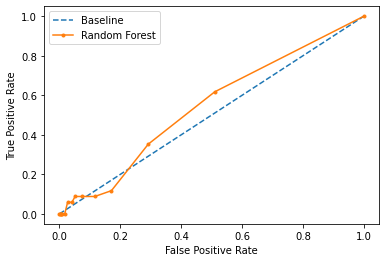

In [23]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

pyplot.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

## SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [25]:
oversample = SMOTE(sampling_strategy=0.1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [26]:
X_train.shape

(3247, 16)

In [27]:
y_train.value_counts()

0.0    2952
1.0     295
Name: outbreak, dtype: int64

In [28]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)

In [29]:
%%time

rf.fit(X_train, y_train)

CPU times: user 365 ms, sys: 137 µs, total: 365 ms
Wall time: 363 ms


RandomForestClassifier(n_estimators=50, random_state=42)

In [30]:
y_pred = rf.predict(X_test)

In [31]:
print(confusion_matrix(y_test, y_pred))

[[1261    3]
 [  34    0]]


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1264
         1.0       0.00      0.00      0.00        34

    accuracy                           0.97      1298
   macro avg       0.49      0.50      0.49      1298
weighted avg       0.95      0.97      0.96      1298



In [33]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

In [34]:
auc = roc_auc_score(y_test, y_pred_proba)

In [35]:
auc

0.5741576693968727

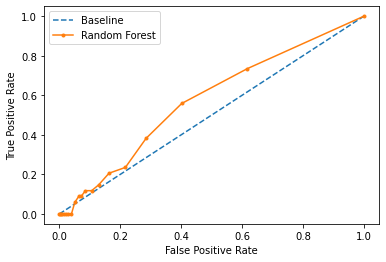

In [36]:
baseline = [0 for _ in range(len(y_test))]
baseline_auc = roc_auc_score(y_test, baseline)

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_proba)

pyplot.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
pyplot.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()

pyplot.show()

## cross validation

## hyperparameter tuning